# Importing Dependecies


In [ ]:
import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D,Conv2D,MaxPooling2D,BatchNormalization,Concatenate
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, CSVLogger,EarlyStopping,ModelCheckpoint
import numpy as np
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
import os
import re
from sklearn.utils import shuffle
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import keras.utils as image 

In [ ]:
from keras import backend as K


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Define Paths

In [ ]:
PATH = "/content/drive/MyDrive/Malaria_Cell_Dataset"
METRICS_PATH="/content/drive/MyDrive/Metrics/Malaria_Cell_Metrics/"
MODEL_NAME="GoogleNet"
print("PWD", PATH)

PWD /content/drive/MyDrive/Malaria_Cell_Dataset


# Define Metrics

In [ ]:
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

In [ ]:
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    false_positives = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return true_negatives / (true_negatives+false_positives + K.epsilon())

In [ ]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# Read Images from Drive

In [ ]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(data, key=alphanum_key)

In [ ]:
data_path = PATH
data_dir_list = sorted_alphanumeric(os.listdir(data_path))
print(data_dir_list)

['Parasitized', 'Uninfected']


In [ ]:
img_data_list = []

for dataset in data_dir_list:
    img_list = sorted_alphanumeric(os.listdir(data_path + '/' + dataset))
    print('Loaded the images of dataset-' + '{}\n'.format(dataset))
    for img in img_list:
        # print(img)
        img_path = data_path + '/' + dataset + '/' + img
        img = image.load_img(img_path, target_size=(32,32))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        x = x/255
        #print('Input image shape:', x.shape)
        img_data_list.append(x)


Loaded the images of dataset-Parasitized

Loaded the images of dataset-Uninfected



In [ ]:

img_data = np.array(img_data_list)
# img_data = img_data.astype('float32')
print(img_data.shape)
img_data = np.rollaxis(img_data, 1, 0)
print(img_data.shape)
img_data = img_data[0]
print(img_data.shape)


(27558, 1, 32, 32, 3)
(1, 27558, 32, 32, 3)
(27558, 32, 32, 3)


# Train & Test Data

In [ ]:
27558/2

13779.0

In [ ]:
num_classes = 2
num_of_samples = img_data.shape[0]
print("sample", num_of_samples)
labels = np.ones((num_of_samples,), dtype='int64')
labels[0:13780] = 1
labels[13780:] = 0
names = ['Parasitized', 'Uninfected']

sample 27558


In [ ]:
Y = np_utils.to_categorical(labels, num_classes)
x, y = shuffle(img_data, Y, random_state=2)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)


# Model Architecture

In [ ]:
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]
input = Input(shape=(img_height, img_width, channel,))


Conv2D_1 = Conv2D(64, (3,3), activation='relu', padding='same')(input)
MaxPool2D_1 = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(Conv2D_1)
BatchNorm_1 = BatchNormalization()(MaxPool2D_1)


tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_1)
tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)

tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_1)
tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)

tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(BatchNorm_1)
tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(tower_3)

output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=1)

Conv2D_2 = Conv2D(128, (3,3), activation='relu', padding='same')(output)
MaxPool2D_2 = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(Conv2D_2)
BatchNorm_2 = BatchNormalization()(MaxPool2D_2)


tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_2)
tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)

tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_2)
tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)

tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(BatchNorm_2)
tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(tower_3)

output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=1)

Conv2D_3 = Conv2D(256, (3,3), activation='relu', padding='same')(output)
MaxPool2D_3 = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(Conv2D_3)
BatchNorm_3 = BatchNormalization()(MaxPool2D_3)

tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_3)
tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)

tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_3)
tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)

tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(BatchNorm_3)
tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(tower_3)

output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=1)

Output = Flatten()(output)
Output = Dense(num_classes, activation='softmax')(Output)
model = Model(inputs=[input], outputs=[Output])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   1792        ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['max_pooling2d[0][0]']          
 alization)                                                                                   

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy',f1,specificity,sensitivity])

In [ ]:
print((METRICS_PATH+MODEL_NAME+".csv"))

/content/drive/MyDrive/Metrics/Malaria_Cell_Metrics/GoogleNet.csv


In [ ]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
csv_logger = CSVLogger(METRICS_PATH+MODEL_NAME+".csv")
model_chekpoint = ModelCheckpoint("GoogleNet.hdf5",monitor = 'val_loss',verbose = 1,save_best_only=True)


# Model Training

In [ ]:
batch_size = 16
data_augmentation = True
epochs = 100

In [ ]:







import time
start = time.time()
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,callbacks=[lr_reducer, csv_logger])
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)  # randomly flip images
    datagen.fit(x_train)
    history = model.fit_generator(datagen.flow(x_train, y_train,
                                            batch_size=batch_size),
                               epochs=epochs,
                               validation_data=(x_test, y_test),callbacks=[lr_reducer,csv_logger])

Using real-time data augmentation.
Epoch 1/100


<ipython-input-26-1769102c3309>:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train, y_train,


1378/1378 [==============================] - 39s 20ms/step - loss: 0.2124 - accuracy: 0.9237 - f1: 0.9237 - specificity: 0.9237 - sensitivity: 0.9237 - val_loss: 0.1455 - val_accuracy: 0.9512 - val_f1: 0.9514 - val_specificity: 0.9514 - val_sensitivity: 0.9514 - lr: 0.0010
Epoch 2/100
1378/1378 [==============================] - 26s 19ms/step - loss: 0.1491 - accuracy: 0.9530 - f1: 0.9530 - specificity: 0.9530 - sensitivity: 0.9530 - val_loss: 0.1351 - val_accuracy: 0.9565 - val_f1: 0.9566 - val_specificity: 0.9566 - val_sensitivity: 0.9566 - lr: 0.0010
Epoch 3/100
1378/1378 [==============================] - 25s 18ms/step - loss: 0.1366 - accuracy: 0.9558 - f1: 0.9558 - specificity: 0.9558 - sensitivity: 0.9558 - val_loss: 0.1353 - val_accuracy: 0.9543 - val_f1: 0.9545 - val_specificity: 0.9545 - val_sensitivity: 0.9545 - lr: 0.0010
Epoch 4/100
1378/1378 [==============================] - 25s 18ms/step - loss: 0.1316 - accuracy: 0.9583 - f1: 0.9583 - specificity: 0.9583 - sensitivity:

# Results

In [ ]:

print('------------Training time is seconds:%s',time.time()-start)
scores = model.evaluate(x_test, y_test, verbose=1)

#history keys and values
print(history.history.keys())
print(history.history.values())

#Metrics for testing
print(scores)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('Test f1:',scores[2])
print('Test sensitivity:',scores[3])
print('Test specificity:',scores[4])
print("Max Test accuracy", max(history.history['val_accuracy']))

------------Training time is seconds:%s 2963.734878063202
173/173 [==============================] - 1s 6ms/step - loss: 0.0938 - accuracy: 0.9673 - f1: 0.9675 - specificity: 0.9675 - sensitivity: 0.9675
dict_keys(['loss', 'accuracy', 'f1', 'specificity', 'sensitivity', 'val_loss', 'val_accuracy', 'val_f1', 'val_specificity', 'val_sensitivity', 'lr'])
dict_values([[0.21236827969551086, 0.14905785024166107, 0.1365969032049179, 0.1315881460905075, 0.12745948135852814, 0.12377744913101196, 0.12187851965427399, 0.11941486597061157, 0.11943528801202774, 0.11615831404924393, 0.11418399214744568, 0.11676106601953506, 0.11110486090183258, 0.11003822833299637, 0.1101110577583313, 0.10786312073469162, 0.10672423988580704, 0.10819423943758011, 0.10343313217163086, 0.10522592812776566, 0.10636982321739197, 0.10146666318178177, 0.10272055864334106, 0.10503056645393372, 0.10194843262434006, 0.10042517632246017, 0.10064893960952759, 0.09924262017011642, 0.09729600697755814, 0.09588757902383804, 0.097

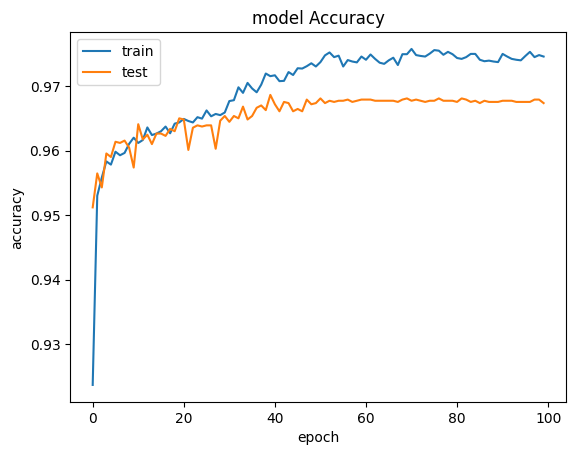

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_acc.png")
plt.show()


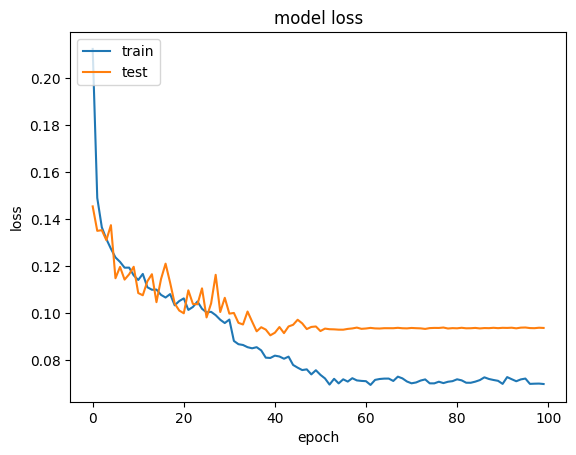

In [ ]:
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_loss.png")
plt.show()


# without aug

In [ ]:
MODEL_NAME="GoogleNet_waug"

In [ ]:
img_height, img_width, channel = x_train.shape[1],x_train.shape[2],x_train.shape[3]
input = Input(shape=(img_height, img_width, channel,))


Conv2D_1 = Conv2D(64, (3,3), activation='relu', padding='same')(input)
MaxPool2D_1 = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(Conv2D_1)
BatchNorm_1 = BatchNormalization()(MaxPool2D_1)


tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_1)
tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)

tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_1)
tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)

tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(BatchNorm_1)
tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(tower_3)

output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=1)

Conv2D_2 = Conv2D(128, (3,3), activation='relu', padding='same')(output)
MaxPool2D_2 = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(Conv2D_2)
BatchNorm_2 = BatchNormalization()(MaxPool2D_2)


tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_2)
tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)

tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_2)
tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)

tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(BatchNorm_2)
tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(tower_3)

output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=1)

Conv2D_3 = Conv2D(256, (3,3), activation='relu', padding='same')(output)
MaxPool2D_3 = MaxPooling2D(pool_size=(2, 2), strides=(2,2))(Conv2D_3)
BatchNorm_3 = BatchNormalization()(MaxPool2D_3)

tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_3)
tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)

tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(BatchNorm_3)
tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)

tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(BatchNorm_3)
tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(tower_3)

output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=1)

Output = Flatten()(output)
Output = Dense(num_classes, activation='softmax')(Output)
model = Model(inputs=[input], outputs=[Output])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_18 (Conv2D)             (None, 32, 32, 64)   1792        ['input_2[0][0]']                
                                                                                                  
 max_pooling2d_6 (MaxPooling2D)  (None, 16, 16, 64)  0           ['conv2d_18[0][0]']              
                                                                                                  
 batch_normalization_3 (BatchNo  (None, 16, 16, 64)  256         ['max_pooling2d_6[0][0]']        
 rmalization)                                                                               

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy',f1,specificity,sensitivity])

In [ ]:
print((METRICS_PATH+MODEL_NAME+".csv"))

/content/drive/MyDrive/Metrics/Malaria_Cell_Metrics/GoogleNet_waug.csv


In [ ]:
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
csv_logger = CSVLogger(METRICS_PATH+MODEL_NAME+".csv")
model_chekpoint = ModelCheckpoint("GoogleNet_waug.hdf5",monitor = 'val_loss',verbose = 1,save_best_only=True)


In [ ]:
batch_size = 16
data_augmentation = False
epochs = 100

In [ ]:
import time
start = time.time()
if not data_augmentation:
    print('Not using data augmentation.')
    history = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,callbacks=[lr_reducer, csv_logger])
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)  # randomly flip images
    datagen.fit(x_train)
    history = model.fit_generator(datagen.flow(x_train, y_train,
                                            batch_size=batch_size),
                               epochs=epochs,
                               validation_data=(x_test, y_test),callbacks=[lr_reducer,csv_logger])

Not using data augmentation.
Epoch 1/100
1378/1378 [==============================] - 18s 12ms/step - loss: 0.1951 - accuracy: 0.9269 - f1: 0.9269 - specificity: 0.9269 - sensitivity: 0.9269 - val_loss: 0.1527 - val_accuracy: 0.9537 - val_f1: 0.9538 - val_specificity: 0.9538 - val_sensitivity: 0.9538 - lr: 0.0010
Epoch 2/100
1378/1378 [==============================] - 15s 11ms/step - loss: 0.1335 - accuracy: 0.9571 - f1: 0.9571 - specificity: 0.9571 - sensitivity: 0.9571 - val_loss: 0.1326 - val_accuracy: 0.9585 - val_f1: 0.9583 - val_specificity: 0.9583 - val_sensitivity: 0.9583 - lr: 0.0010
Epoch 3/100
1378/1378 [==============================] - 14s 10ms/step - loss: 0.1216 - accuracy: 0.9605 - f1: 0.9605 - specificity: 0.9605 - sensitivity: 0.9605 - val_loss: 0.1528 - val_accuracy: 0.9557 - val_f1: 0.9558 - val_specificity: 0.9558 - val_sensitivity: 0.9558 - lr: 0.0010
Epoch 4/100
1378/1378 [==============================] - 14s 10ms/step - loss: 0.1206 - accuracy: 0.9600 - f1: 0.

In [ ]:

print('------------Training time is seconds:%s',time.time()-start)
scores = model.evaluate(x_test, y_test, verbose=1)

#history keys and values
print(history.history.keys())
print(history.history.values())

#Metrics for testing
print(scores)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
print('Test f1:',scores[2])
print('Test sensitivity:',scores[3])
print('Test specificity:',scores[4])
print("Max Test accuracy", max(history.history['val_accuracy']))

------------Training time is seconds:%s 1651.9999413490295
173/173 [==============================] - 1s 6ms/step - loss: 0.2295 - accuracy: 0.9581 - f1: 0.9583 - specificity: 0.9583 - sensitivity: 0.9583
dict_keys(['loss', 'accuracy', 'f1', 'specificity', 'sensitivity', 'val_loss', 'val_accuracy', 'val_f1', 'val_specificity', 'val_sensitivity', 'lr'])
dict_values([[0.19508156180381775, 0.1334993690252304, 0.12161998450756073, 0.12063942104578018, 0.11281415075063705, 0.10925908386707306, 0.10504531115293503, 0.10132721811532974, 0.09988325834274292, 0.09812690317630768, 0.07709972560405731, 0.06985214352607727, 0.062340736389160156, 0.05724639818072319, 0.051107537001371384, 0.04617825523018837, 0.030418572947382927, 0.026584705337882042, 0.02258499339222908, 0.019964419305324554, 0.017751120030879974, 0.012897966429591179, 0.012586807832121849, 0.010445639491081238, 0.009686463512480259, 0.008239669725298882, 0.0089860325679183, 0.008134768344461918, 0.007829864509403706, 0.007194836

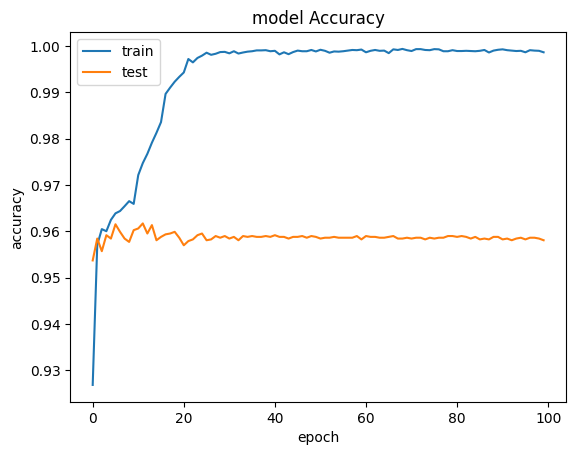

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_acc.png")
plt.show()


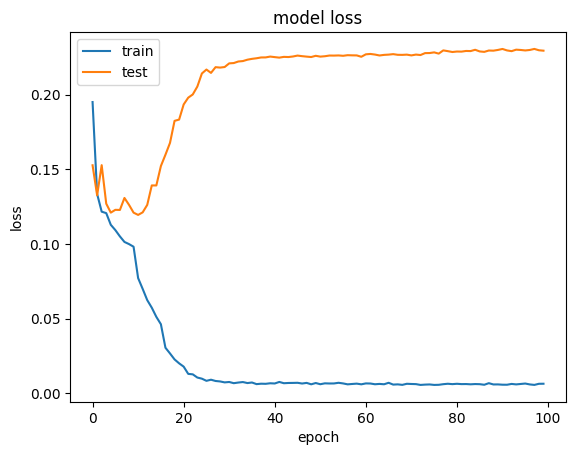

In [ ]:
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig(METRICS_PATH+MODEL_NAME+"_loss.png")
plt.show()
